In [89]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [90]:
import seaborn as sns
sns.set_context('poster', font_scale=1.25)

In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
from LB_D2Q9 import pipe_cython as lb
from LB_D2Q9 import opencl_dimensionless as lb_cl

Let's setup the simulation parameters. See what our non-dimensional numbers are.

There is something wrong with the pressure gradient.

# Checking if the simulations are dimensionless

## sim 1

In [111]:
D = 1. # meter
rho = 1. # kg/m^3
nu = 1. # Viscosity, m^2/s

pressure_grad = -10 # Pa/m

pipe_length = 2*D # meter

sim1 = lb_cl.Pipe_Flow(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                       N=50, time_prefactor=1.,
                       two_d_local_size = (32, 32), three_d_local_size = (32, 32, 1))

Reynolds number: 1.5625
inlet rho: 1.0155136
outlet rho: 1.0
omega 0.413223140496
2d global: (128, 64)
2d local: (32, 32)
3d global: (128, 64, 9)
3d local: (32, 32, 1)
The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 7.5.23
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1610 MB
Maximum work group size 1024
Maximum work item dimensions 3
Maximum work item size [1024, 1024, 64]
---------------------------
This context is associated with  1 devices


In [112]:
D = 1. # meter
rho = 1. # kg/m^3
nu = 1. # Viscosity, m^2/s

pressure_grad = -10 # Pa/m

pipe_length = 2*D # meter

sim2 = lb_cl.Pipe_Flow(diameter=D, rho=rho, viscosity=nu, pressure_grad=pressure_grad, pipe_length=pipe_length,
                       N=75, time_prefactor=1.,
                       two_d_local_size = (32, 32), three_d_local_size = (32, 32, 1))

Reynolds number: 1.5625
inlet rho: 1.00687217778
outlet rho: 1.0
omega 0.413223140496
2d global: (160, 96)
2d local: (32, 32)
3d global: (160, 96, 9)
3d local: (32, 32, 1)
The platforms detected are:
---------------------------
NVIDIA CUDA NVIDIA Corporation version: OpenCL 1.2 CUDA 7.5.23
The devices detected on platform NVIDIA CUDA are:
---------------------------
GeForce GTX TITAN Black [Type: GPU ]
Maximum clock Frequency: 980 MHz
Maximum allocable memory size: 1610 MB
Maximum work group size 1024
Maximum work item dimensions 3
Maximum work item size [1024, 1024, 64]
---------------------------
This context is associated with  1 devices


In [113]:
time_to_run = 5 # seconds

In [114]:
num_steps = int(time_to_run/sim1.delta_t)
print 'Running for', num_steps

Running for 12500


In [115]:
sim1.run(num_steps)

In [116]:
num_steps = int(time_to_run/sim2.delta_t)
print 'Running for', num_steps

Running for 28124


In [117]:
sim2.run(num_steps)

<matplotlib.colorbar.Colorbar instance at 0x7fe3b193bea8>

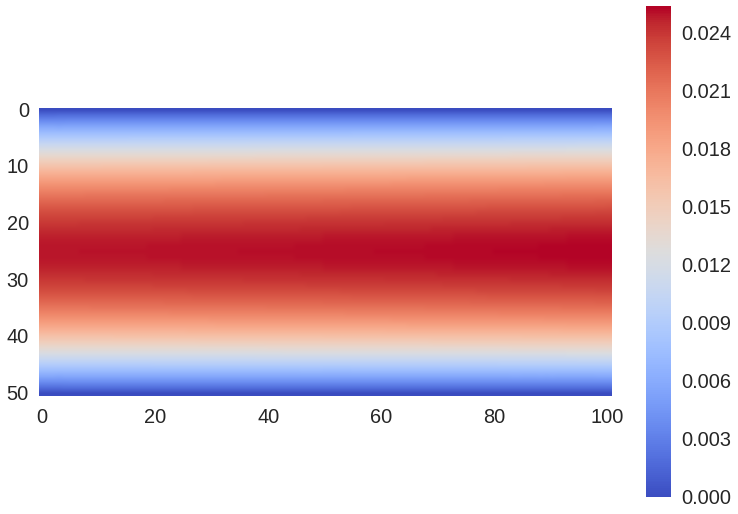

In [120]:
fields = sim1.get_fields()
plt.imshow(fields['u'].T, cmap=cm.coolwarm)
plt.grid(False)

plt.colorbar()

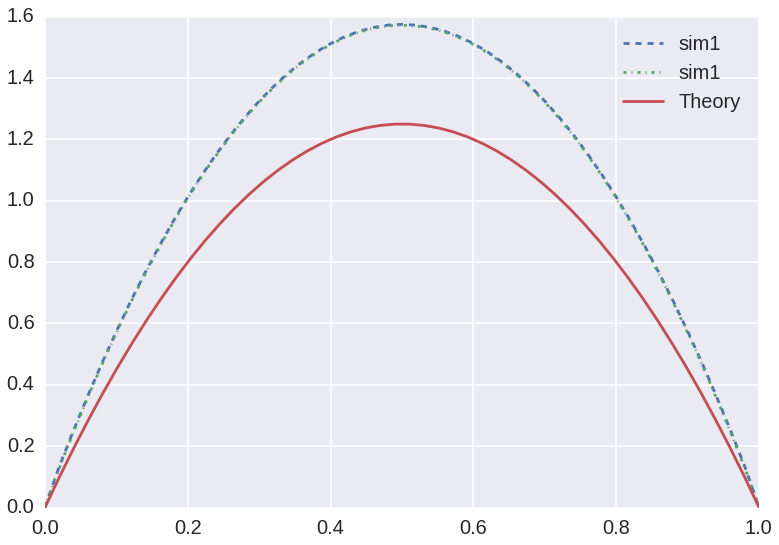

In [127]:
fields1 = sim1.get_physical_fields()
fields2 = sim2.get_physical_fields()

x_values = np.arange(fields1['u'].T.shape[0])*sim1.delta_x*sim1.L
# Get the mean velocity in the x direction
mean_u = fields1['u'].T.mean(axis=1)
plt.plot(x_values, mean_u, label='sim1', ls='--')

x_values = np.arange(fields2['u'].T.shape[0])*sim2.delta_x*sim2.L
mean_u = fields2['u'].T.mean(axis=1)
plt.plot(x_values, mean_u, label='sim1', ls='-.')

prefactor = (1./(2*rho*nu))*pressure_grad
y = np.linspace(0, D)

predicted = prefactor*y*(y-D)
# Convert non-dim predicted

plt.plot(y, predicted, label='Theory')

plt.legend(loc='best')

Well, they are *extremely* close now. That's good at least.

Hm. They don't line up. IDK why. Weirdly, the pressure gradient does not work out. Why? Changing diameter does not mess things up.

WOW wtf lol

 So yes. The nondimensional fields are the same when we convert from simulation to simulation. *But*, they do not match our physical expectations...why.

Let's calculate the reynold's #'s of our simulation.

In [83]:
f1 = sim1.get_fields()

In [84]:
u_lb = np.max(np.abs(f1['u']))
N_lb = sim1.N
nu_lb = sim1.lb_viscosity

print (u_lb*N_lb)/nu_lb

1.95534105135


In [87]:
f2 = sim2.get_fields()

In [88]:
u_lb = np.max(f2['u'])
N_lb = sim2.N
nu_lb = sim2.lb_viscosity

print (u_lb*N_lb)/nu_lb

1.95655971766


Ok. The reynold's #'s are the same for the two, but are not what we expect analytically, so there is something wrong. Good, making progress!

Ok. As far as I can tell, the only issue is that the system is off by a constant factor. Probably dealing with density. Changing space is ok, i.e. the net result is the same. So we are in pretty good shape overall.